# CNN-lytical Assignment-4
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image segmentation.

* Segmentation is the task of classifying pixels into classes - whether those pixels are a part of a certain object or not.

* The model we will be using is UNet, you can read about it here - https://arxiv.org/pdf/1505.04597.pdf

* Much of what you learnt in Assignments 2 and 3 will carry over to this assignment. The structure would overall remain the same - a Dataset class, a Model class and a Training loop. However, significant effort would go into creating these because UNet is a complex model in itself.

* **No processing of the data should happen outside the Dataset class, which should take in raw inputs directly from the unpickled object**.

* Because this would be the first time you deal with a complex model, feel free to refer to this video - https://www.youtube.com/watch?v=u1loyDCoGbE - Abhishek Thakur (one of the top Kaggle GMs) walks you through the design of the model and how you can make subclasses to make your code clean and reusable.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [4]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F 
import torchvision
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pickle 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import torch.backends.cudnn as cudnn

def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

## Load *Dataset*
Use the [pickle file](https://drive.google.com/file/d/1EiCGYDhztVLBPmpS2_SsFgfrWPDtsDsk/view?usp=sharing) shared for this assignment here.

In [5]:
# load the data set

# mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/gdrive')

# load the data set
with open('/content/gdrive/My Drive/CNN/train_carvana.pkl', 'rb') as f:
    data = pickle.load(f)

X = data['X']
y = data['y']

# normalisation
# std_vec=np.std(x_prev,axis=0)
# std_vec[np.where(std_vec==0)]=1e-22
# X=(x_prev-np.mean(x_prev,axis=0))/std_vec

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
X_train=X[0:60]
X_test=X[60:80] 
y_train=y[0:60]
y_test =y[60:80]


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In the following cell, display one data-point in each line, with three images - the original image, the segmentation mask and the two of them superposed over each other.

(60, 1280, 1918, 3)
(60, 1280, 1918)


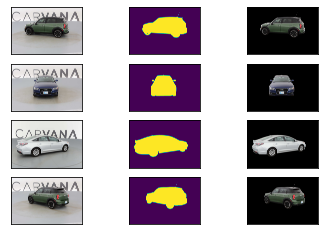

In [6]:
# display 4 datapoints as described above 
print(X_train.shape)
print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)
random_indices = np.random.choice(X.shape[0]-1, size=4, replace=False)

for i in range(4):
    plt.subplot(4,3,i*3+1)
    tmp=X[random_indices[i]]
    plt.imshow(tmp)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(4,3,i*3+2)
    plt.imshow(y[random_indices[i]])
    plt.xticks([])
    plt.yticks([])
    tmp[y[random_indices[i]]<=0]=0
    plt.subplot(4,3,i*3+3)
    plt.imshow(tmp)
    plt.xticks([])
    plt.yticks([])


## Creating a Dataset Class
Create a Dataset class like in the previous assignment. However, this time you **should** perform augmentation.

**Note -** While initializing the dataset class object, make sure you only pass the numpy arrays for images and masks. So the ```__init__``` function should look like
```
    def __init__(self, X, y):
```

In [7]:
# define your dataset class
class ImageDataset(Dataset):
    def __init__(self, X, y):

        self.img_masks = y
        self.imgs = X
        transform_with_aug = A.Compose(
            [   A.Rotate(limit=45, p=0.7),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.3),
                A.pytorch.ToTensor(),            
                ]
        )
             
        # transform_2=A.compose(
        #     [        A.Normalize(
        #              mean=[0.485, 0.456, 0.406],
        #              std=[0.229, 0.224, 0.225]),
        #             ),
        #     ]
        # )   

        self.transform = transform_with_aug
        
    def __len__(self):
        return len(self.img_masks)
        
    def __getitem__(self, idx):
        image = self.imgs[idx]
        mask = self.img_masks[idx]
        if self.transform:
          augmentations = self.transform(image=image, mask=mask)
          image = augmentations["image"]
          mask = augmentations["mask"]
        return image, mask





## ```nn.Module``` for your model
Take inspiration from this video - https://www.youtube.com/watch?v=u1loyDCoGbE. Don't just blindly copy the code, you might not need a model as big as the original one.

In [8]:
# define a child class of nn.Module for your model
# specify the architecture here itself
# if necessary, make submodules in different cells for structured code

def double_conv(in_c,out_c):
  conv=nn.Sequential(
      nn.Conv2d(in_c, out_c, kernel_size=3),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_c, out_c, kernel_size=3),
      nn.ReLU(inplace=True),   
  )
  return conv

def crop_img(tensor,target_tensor):
  target_size_x=target_tensor.size()[2]
  tensor_size_x=tensor.size()[2]

  target_size_y=target_tensor.size()[3]
  tensor_size_y=tensor.size()[3]
  
  delta_x=tensor_size_x - target_size_x
  delta_x= delta_x//2
  
  delta_y=tensor_size_y - target_size_y
  delta_y= delta_y//2
  if ((tensor_size_x - target_size_x)%2==1) and ((tensor_size_y - target_size_y)%2==1):
    return tensor[:,:,delta_x:tensor_size_x-delta_x-1,delta_y:tensor_size_y-delta_y-1]
  elif ((tensor_size_x - target_size_x)%2==0) and ((tensor_size_y - target_size_y)%2==1):
    return tensor[:,:,delta_x:tensor_size_x-delta_x,delta_y:tensor_size_y-delta_y-1]
  elif ((tensor_size_x - target_size_x)%2==1) and ((tensor_size_y - target_size_y)%2==0):
    return tensor[:,:,delta_x:tensor_size_x-delta_x-1,delta_y:tensor_size_y-delta_y-1]
  else:
    return tensor[:,:,delta_x:tensor_size_x-delta_x,delta_y:tensor_size_y-delta_y]

def padding(x2,x1):
  diffY = x2.size()[2] - x1.size()[2]
  diffX = x2.size()[3] - x1.size()[3]

  x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
  return x1

class UNet(nn.Module):

    def __init__(self):
         super(UNet, self).__init__()

         self.max_pool=   nn.MaxPool2d(2, 2)
         self.down_conv_1=  double_conv(3,16)
         self.down_conv_2=  double_conv(16,32)
         self.down_conv_3=  double_conv(32,64)
         self.up_trans_3 = nn.ConvTranspose2d(in_channels=64,
                                              out_channels=32,
                                              kernel_size=2,
                                              stride=2)
         self.up_conv_3= double_conv(64,32)
         
         self.up_trans_4 = nn.ConvTranspose2d(in_channels=32,
                                              out_channels=16,
                                              kernel_size=2,
                                              stride=2)
         self.up_conv_4= double_conv(32,16)
         
         self.out= nn.Conv2d(
             in_channels=16,
             out_channels=1,
             kernel_size=1
         )
                
    def forward(self, img):
         #encoder
         x1= self.down_conv_1(img)#
         x2=self.max_pool(x1)
         x3= self.down_conv_2(x2)#
         x4=self.max_pool(x3)
         x5= self.down_conv_3(x4)#
                  
         x = self.up_trans_3(x5)
         x = padding(x3,x)
         x=self.up_conv_3(torch.cat([x,x3],1))
         
         x = self.up_trans_4(x)
         x=padding(x1,x)
         x=self.up_conv_4(torch.cat([x,x1],1))
         x=padding(img,x)
         
         x=self.out(x)
         return x  



## Training loop
As in the previous assignments, you will write a training loop here. Learning from past experience, do maintain a validation set and monitor loss/accuracy on that to save the best model (instead of having to interrupt execution).

In [9]:
def train(model, optimizer, criterion, train_loader,test_loader, display_step=None):
    for i, (images, masks) in enumerate(train_loader):   
         
         # Forward pass
         images, masks = images.cuda(), masks.cuda()
         outputs = model(images.float())
        #  print(masks)
         loss = criterion(outputs, masks)
         # Backward and optimize
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()

    print("Train Loss is: ",loss.item())
    test_features, test_labels = next(iter(test_loader))
    test_features = test_features.cuda()
    predicted=predict(model,test_features)
    # print(predicted.shape)
    # print(np.max(predicted.astype(int)))
    val=accuracy(predicted,(test_labels.cpu().numpy()))
    print("Test Accuracy is: ",val)
    return val

## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [10]:
def init_weights(model_instance):
    if isinstance(model_instance, nn.Linear) or isinstance(model_instance, nn.Conv2d) or isinstance(model_instance,nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform_(model_instance.weight)
        model_instance.bias.data.fill_(0.001)


## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**, the mask you predict.

The accuracy function would be the number of pixels you get a correct mask for.

In [11]:
def predict(model, X_test):
    outputs=model((torch.tensor(X_test)).float())
    sigm=nn.Sigmoid()
    # print(torch.min(outputs))
    # print(torch.max(outputs))
    predicted = sigm(outputs)
    # print(torch.min(predicted))
    # print(torch.max(predicted))
    predicted = (predicted > 0.25)
    
    return predicted.cpu().numpy()

In [12]:
def accuracy(pred, masks):
    frac_correct = np.mean(pred == masks)
    return 100*frac_correct

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [13]:
#needs change 

num_epochs = 200
batch_size = 2
learning_rate = 0.05 
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

train_dataset = ImageDataset(X_train,y_train)
test_dataset = ImageDataset(X_test,y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

network=UNet()
# move tensors to GPU if CUDA is available
if train_on_gpu:
  network = network.cuda()
  network = torch.nn.DataParallel(network)
  cudnn.benchmark = True

criterion = nn.BCEWithLogitsLoss()

#optimizer=torch.optim.Adam(network.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)

#initiate
network.apply(init_weights)
best_model=network
curr_acc=0

for epoch in range(num_epochs):
  print("Epoch: ",epoch)
  value_acc=train(network, optimizer, criterion, train_dataloader, test_dataloader, 1)
  if(value_acc>curr_acc):
    best_model=network
    curr_acc=value_acc
    
final_model=best_model

CUDA is available!  Training on GPU ...
Epoch:  0
Train Loss is:  0.4836820363998413


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Test Accuracy is:  75.87016912148071
Epoch:  1
Train Loss is:  0.477642297744751
Test Accuracy is:  76.6274683915537
Epoch:  2
Train Loss is:  0.43314406275749207
Test Accuracy is:  75.34021848931178
Epoch:  3
Train Loss is:  0.42045044898986816
Test Accuracy is:  80.03498924661105
Epoch:  4
Train Loss is:  0.5461214184761047
Test Accuracy is:  82.1114727254953
Epoch:  5
Train Loss is:  0.5434759259223938
Test Accuracy is:  71.97171940172055
Epoch:  6
Train Loss is:  0.5925548672676086
Test Accuracy is:  63.83439781021898
Epoch:  7
Train Loss is:  0.42268115282058716
Test Accuracy is:  78.37069864442128
Epoch:  8
Train Loss is:  0.3555090129375458
Test Accuracy is:  75.41803799530761
Epoch:  9
Train Loss is:  0.4201030433177948
Test Accuracy is:  82.88993254692389
Epoch:  10
Train Loss is:  0.4581461548805237
Test Accuracy is:  76.46225723409802
Epoch:  11
Train Loss is:  0.63685142993927
Test Accuracy is:  48.49660290667362
Epoch:  12
Train Loss is:  0.46072471141815186
Test Accuracy 

## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [14]:
# load the model, use predict function
masks_pred=[]
masks_actual=[]
imgs_used=[]

with torch.no_grad():
    nums=0
    sum_accuracy=0
    
    for i, (images, masks) in enumerate(test_dataloader):
      images=images.cuda()   
      predicted=predict(final_model,images)
      if(nums<10):
        masks_pred.append(predicted[0])
        masks_actual.append(masks[0].cpu().numpy())
        imgs_used.append(images[0].cpu().numpy())
      nums+=1
      val=accuracy(predicted,masks.cpu().numpy())
      print(val)
      sum_accuracy+=val
    
    print(sum_accuracy/nums)

    # predicted_arr[i]=predicted 
    #  predicted=predict(final_model,X_test) 
    #  print(accuracy(predicted,y_test.flatten()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


81.4969409867049
79.97016341892596
85.44549172314912
87.78826414233578
78.91480383211679
81.68917818039625
93.96404946558916
94.10832410062565
86.4656584006778
80.39840491397288
85.02412791644943


This task is not like the usual classification task, you also need to check how the model is doing visually to appreciate the level of learning. Visualize 10 outputs below (as you did in the visualization cell near the top of the notebook).

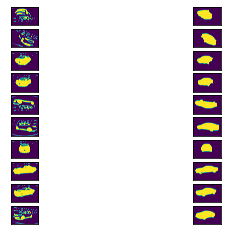

In [15]:
for i in range(10):
    # plt.subplot(10,2,i*2+1)
    # 
    # tmp=np.moveaxis(imgs_used[i], 0, -1)
    # plt.imshow(tmp)
    # plt.xticks([])
    # plt.yticks([])
    plt.subplot(10,2,i*2+1)
    plt.imshow(masks_pred[i][0])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(10,2,i*2+2)
    plt.imshow(masks_actual[i][0])
    plt.xticks([])
    plt.yticks([])


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Also create a file ```dataset.py``` with the dataset class and all necessary imports. Other than this, save the trained model in a file named ```ass_4.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py```, ```dataset.py``` class files and the ```ass_4.pt``` model-weights file to the repository.

Note that if you use submodules, all of them should go into the `model.py` file.

In [16]:
from google.colab import files
torch.save(final_model, 'ass_4.pt')
files.download('ass_4.pt') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check if it got saved right!

In [17]:
# load the model, use predict function
